**Objective**: Test whether the environment conditions influence the exploration efficiency.

Compare
- ballistic motion
- Lévy walks (for different values of $\mu$)
- exponential walks (for different values of $\alpha$)
- Brownian walks

with respect to the environment variables
1. Environment Size
2. Number of Food Particles
3. Food Buffer Size

In [ ]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params, agent_classes
from simulation import Simulation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from multiprocessing import Pool
from tqdm import tqdm
from pathlib import Path
from config import DATA_PATH, MAX_PROCESSES
import pickle
import shutil
import config

folder = 'exploration'
path = Path(DATA_PATH) / folder
path.mkdir(parents=True, exist_ok=True)
params = Params.from_json('parameters.json')
params.save = False

agent_configuration = {
    'ballistic': None,
    'brownian': None,
    'levy': [0.5, 1.01, 2.0, 3.0],
    'exponential': [0.5, 1.0, 2.0, 3.0]
}

agents = []
for key, values in agent_configuration.items():
    if values is None:
        agents.append(key)
    else:
        for value in values:
            agents.append(f"{key} {value}")

shades_exponential = [cm.Blues(i) for i in np.linspace(0.9, 0.3, len(agent_configuration['exponential']))]
shades_levy = [cm.Oranges(i) for i in np.linspace(0.9, 0.3, len(agent_configuration['levy']))]

def plot_lines(data, x_values):
    levy_line_count = 0
    exponential_line_count = 0
    for agent_type, values in data.items():
        type = agent_type.split(' ')[0]
        if type == 'exponential':
            linestyle = ':'
            color = shades_exponential[exponential_line_count]
            exponential_line_count += 1
        elif type == 'levy':
            linestyle = '-'
            color = shades_levy[levy_line_count]
            levy_line_count += 1
        elif type == 'brownian':
            linestyle = '--'
            color = 'green'
        elif type == 'ballistic':
            linestyle = '-.'
            color = 'grey'
        plt.plot(x_values, values, linestyle=linestyle, color=color, label=agent_type)

shutil.copyfile(config.PROJECT_ROOT_PATH / 'code/parameters.json', path / 'parameters.json')
print(vars(params))

{'agent': <class 'agent.ReservoirAgent'>, 'eat_radius': 0.5, 'velocity': 1, 'perception_radius': 0.5, 'mu': 1.01, 'alpha': 1, 'num_food': 100, 'size': 200, 'border_buffer': 5, 'food_buffer': 2, 'empty': False, 'resetting_boundary': True, 'seed': 34, 'population_size': 50, 'elite_fraction': 0.4, 'mutation_fraction': 0.4, 'mutation_rate': 0.1, 'mutation_strength': 0.1, 'tolerance': 0.1, 'total_time': 499, 'delta_t': 1, 'num_epochs': 1, 'iterations_per_epoch': 10, 'intervall_save': 5, 'save': False, 'num_neurons': 1000, 'burn_in_time': 100, 'mean': 0, 'standard_deviation': 0.032, 'evolve': False, 'simulation_steps': 500}


# 1. Environment Size

In [ ]:
plt.clf()
data = {identifier: [] for identifier in agents}
params.num_food = 100
params.food_buffer = 2
size_range = np.arange(50, 500, 5)

def run_simulation(args):
    size, identifier = args
    agent = identifier.split(' ')[0]
    params.size = size
    if agent == 'levy':
        params.mu = float(identifier.split(' ')[1])
    elif agent == 'exponential':
        params.alpha = float(identifier.split(' ')[1])
    sim = Simulation(params, agent_classes[agent])
    return identifier, np.mean(sim.run(folder))

tasks = []
for size in size_range:
    for identifier in agents:
        tasks.append((size, identifier))

with Pool(MAX_PROCESSES) as pool:
    results = list(tqdm(pool.imap_unordered(run_simulation, tasks), total=len(tasks)))

for identifier, fitness in results:
    data[identifier].append(fitness)

with open(path / 'environment_sizes_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
with open(path / 'environment_sizes_data.pkl', 'rb') as f:
    data = pickle.load(f)

plt.figure(figsize=(16,8))

plot_lines(data, size_range)

plt.legend()
plt.xlabel('Environment Size')
plt.ylabel('Fitness')

plt.savefig(path / 'environment_sizes.svg', format='svg')

# 2. Number of Food Particles

Note: simulations with higher numbers of food particles take longer to run.

In [4]:
plt.clf()
data = {identifier: [] for identifier in agents}
params.size = 200
params.food_buffer = 2
num_food_range = np.arange(10, 200, 5)

def run_simulation(args):
    num_food, identifier = args
    agent = identifier.split(' ')[0]
    params.num_food = num_food
    if agent == 'levy':
        params.mu = float(identifier.split(' ')[1])
    elif agent == 'exponential':
        params.alpha = float(identifier.split(' ')[1])
    sim = Simulation(params, agent_classes[agent])
    return identifier, np.mean(sim.run(folder))

tasks = []
for num_food in num_food_range:
    for identifier in agents:
        tasks.append((num_food, identifier))

with Pool(MAX_PROCESSES) as pool:
    results = list(tqdm(pool.imap_unordered(run_simulation, tasks), total=len(tasks)))

for identifier, fitness in results:
    data[identifier].append(fitness)

with open(path / 'environment_num_food_data.pkl', 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 494/494 [1:15:30<00:00,  9.17s/it]


<Figure size 640x480 with 0 Axes>

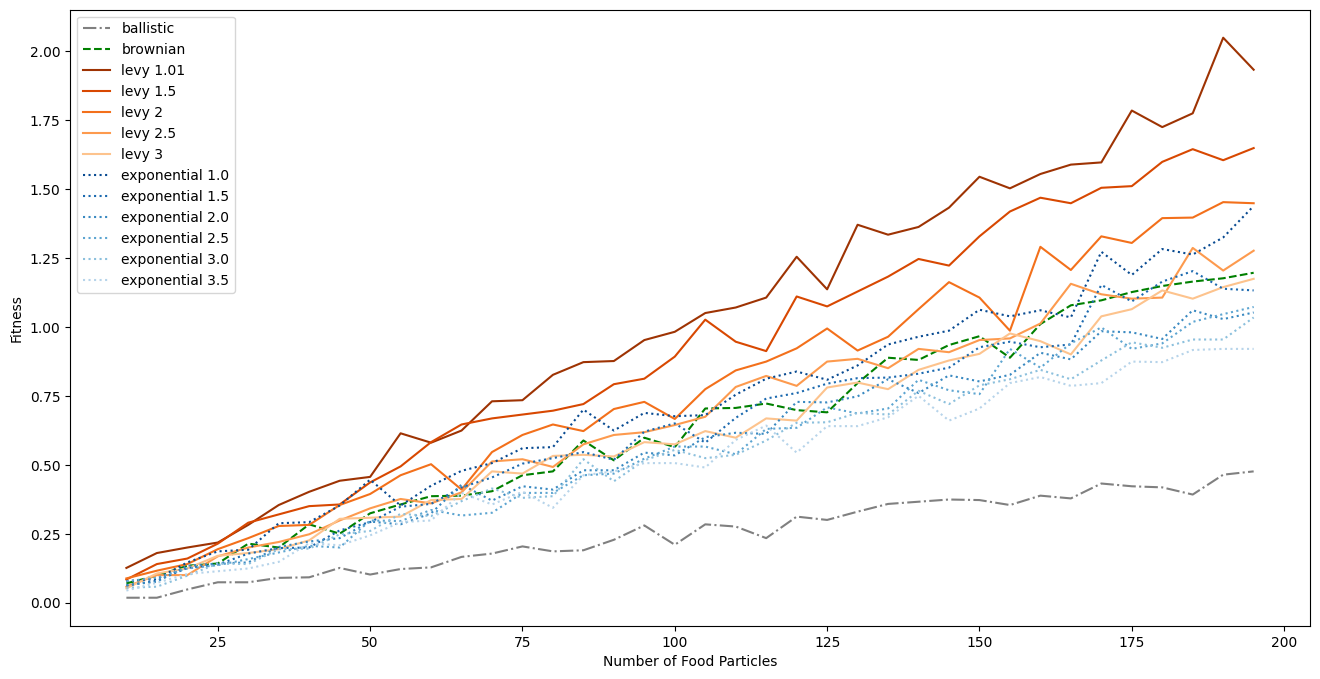

In [ ]:
with open(path / 'environment_num_food_data.pkl', 'rb') as f:
    data = pickle.load(f)

plt.figure(figsize=(16,8))

plot_lines(data, num_food_range)

plt.legend()
plt.xlabel('Number of Food Particles')
plt.ylabel('Fitness')

plt.savefig(path / 'number_of_food_particles.svg', format='svg')

# 3. Food Buffer Size

In [6]:
plt.clf()
data = {identifier: [] for identifier in agents}
params.size = 200
params.num_food = 100

food_buffer_range = np.arange(1, 10, 1)

def run_simulation(args):
    food_buffer, identifier = args
    agent = identifier.split(' ')[0]
    params.food_buffer = food_buffer
    if agent == 'levy':
        params.mu = float(identifier.split(' ')[1])
    elif agent == 'exponential':
        params.alpha = float(identifier.split(' ')[1])
    sim = Simulation(params, agent_classes[agent])
    return identifier, np.mean(sim.run(folder))

tasks = []
for food_buffer in food_buffer_range:
    for identifier in agents:
        tasks.append((food_buffer, identifier))

with Pool(MAX_PROCESSES) as pool:
    results = list(tqdm(pool.imap_unordered(run_simulation, tasks), total=len(tasks)))

for identifier, fitness in results:
    data[identifier].append(fitness)

with open(path / 'environment_food_buffer_data.pkl', 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 117/117 [17:32<00:00,  8.99s/it]


<Figure size 640x480 with 0 Axes>

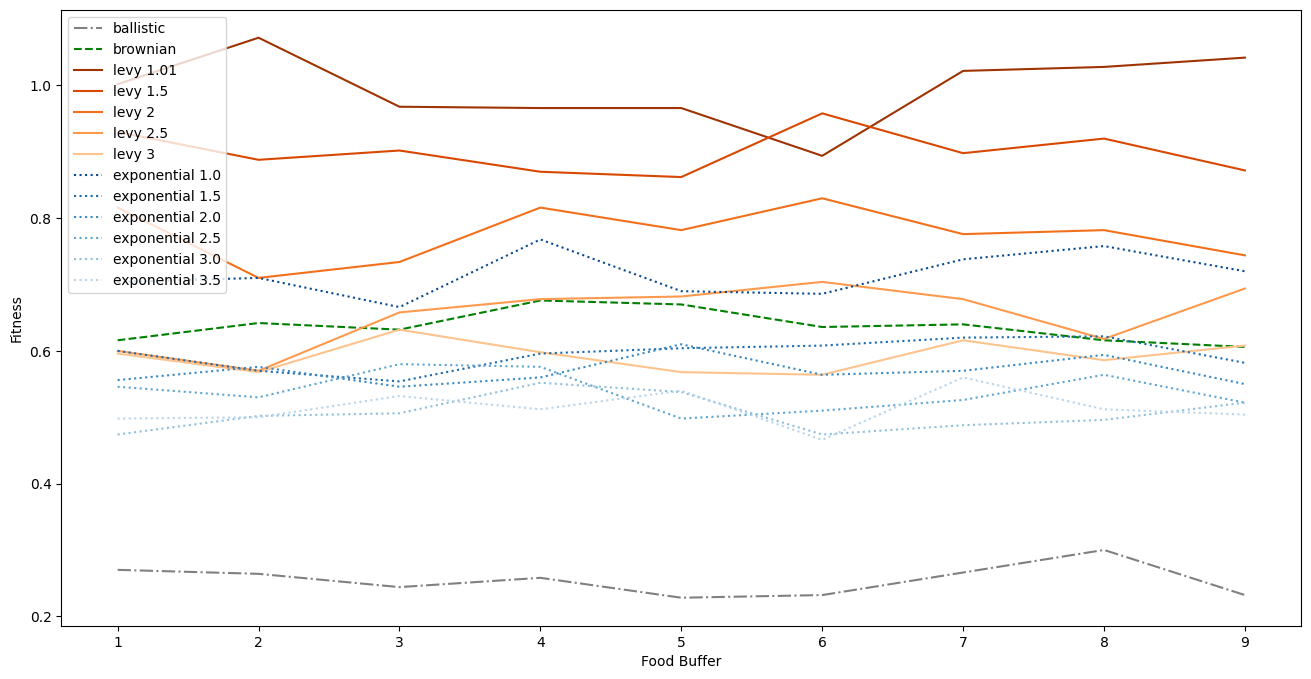

In [25]:
with open(path / 'environment_food_buffer_data.pkl', 'rb') as f:
    data = pickle.load(f)

plt.figure(figsize=(16,8))

plot_lines(data, food_buffer_range)

plt.legend()
plt.xlabel('Food Buffer')
plt.ylabel('Fitness')

plt.savefig(path / 'food_buffer.svg', format='svg')